In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from read_json import read_json  # for json files
import numpy as np
from plots import plot_histogram
from datetime import datetime
from scipy.fftpack import fft

In [120]:
data = pd.read_csv("data_sample.csv")
format = "%Y-%m-%dT%H:%M:%S.%fZ"
data['@timestamp'] = data['@timestamp'].apply(lambda x: datetime.strptime(x, format))

In [117]:
date_sorted = data.sort_values(by=['@timestamp'], ascending=True)

In [134]:
def process_network(network):
    out = network['out']['bytes']
    in_ = network['in']['bytes']
    return out, in_

def process_cpu(cpu):
    cores = cpu['cores']
    idle = cpu['idle']['pct'] / cores
    user = cpu['user']['pct'] / cores
    system = cpu['system']['pct'] / cores

    return idle#, user, system

def process_memory(memory):
    total = memory['actual']['used']['bytes'] + memory['free']

    actual = 1 - memory['actual']['used']['bytes'] / total
    swap = 1 - (memory['swap']['free'] / memory['swap']['total'])

    return swap#, actual

def divide(x):
    # Divide datatypes
    networks = []
    network_times = []

    cpus = []
    cpus_times = []

    memories = []
    memories_times = []

    for i, row in x.iterrows():
        sys = row['system']
        time = row['@timestamp']

        if type(sys) == float:
            continue

        s = sys.replace("\'", "\"")
        s = read_json(s)
        data_type = list(s.keys())[0]

        if data_type == 'network':
            info = process_network(s['network'])
            networks.append(info)
            network_times.append(time)

        if data_type == 'cpu':
            info = process_cpu(s['cpu'])
            cpus.append(info)
            cpus_times.append(time)

        if data_type == 'memory':
            info = process_memory(s['memory'])
            memories.append(info)
            memories_times.append(time)
    return(networks,network_times,cpus,cpus_times,memories,memories_times)

def plot(name):
    tname = "{'name': '" + name + "'}"

    develop_server = date_sorted.loc[data.host == tname ]
    develop_server = develop_server.dropna(subset=['system'])
    networks,network_times,cpus,cpus_times,memories,memories_times = divide(develop_server)

    fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True,figsize=(14,8))
    fig.suptitle(name + " server")

    #ax1.plot(network_times, networks)
    #ax1.set_title("network v time")
    #ax1.legend(["out","in"], fontsize=8,loc='upper right')

    ax2.plot(cpus_times, cpus)
    ax2.set_title("cpus v time")
    ax2.legend(["idle","user","system"], fontsize=8,loc='upper right')

    ax3.plot(memories_times, memories)
    ax3.set_title("memories v time")
    ax3.legend(["swap", "actual", "free"], fontsize=8,loc='upper right')

    plt.xticks(rotation=45)

    plt.show()

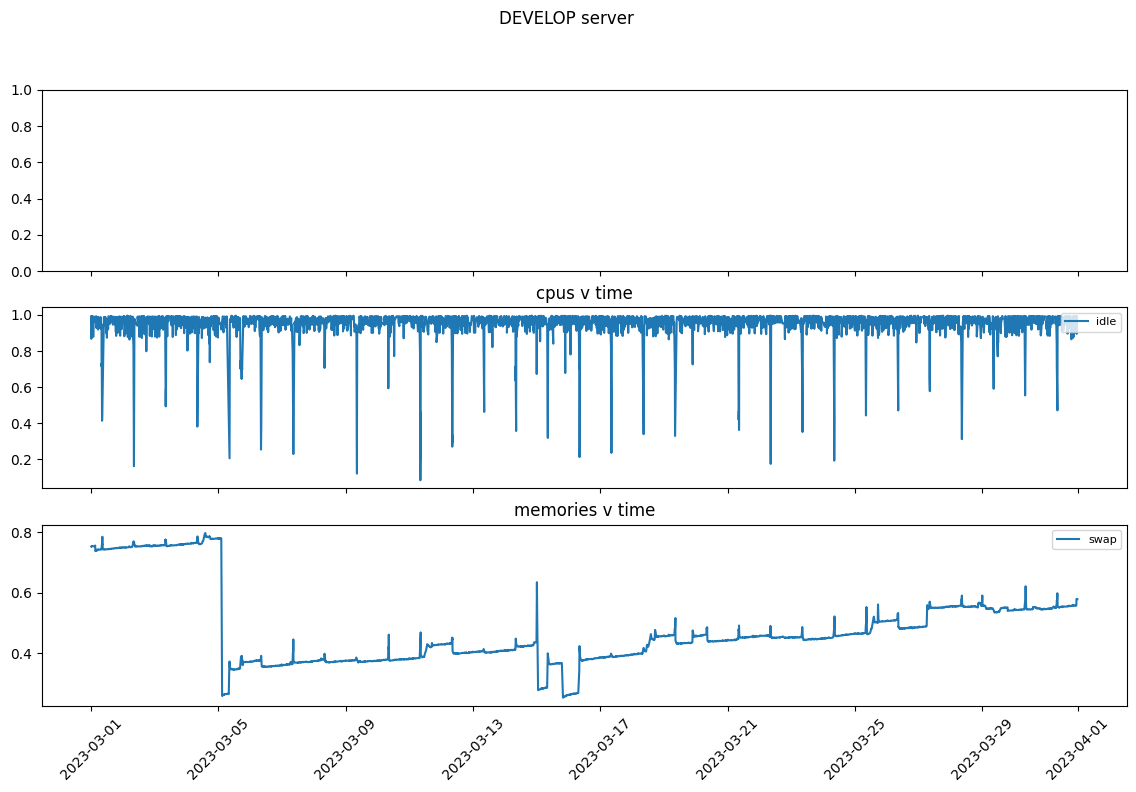

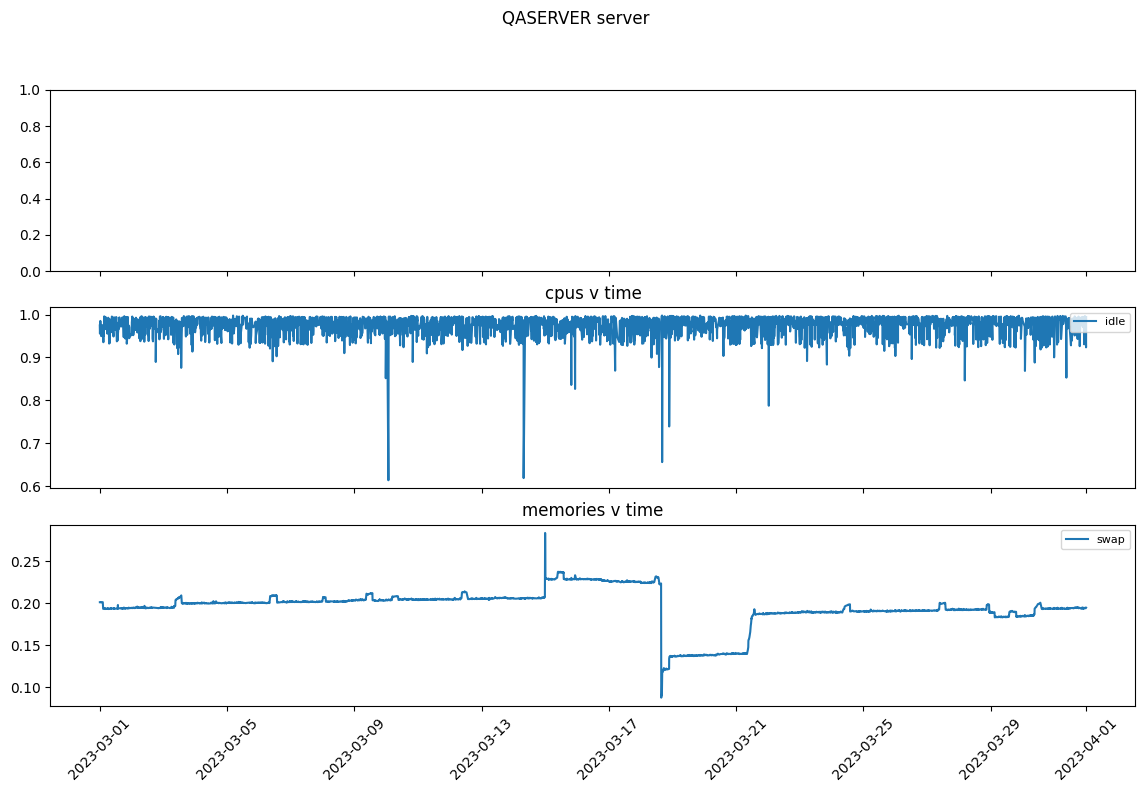

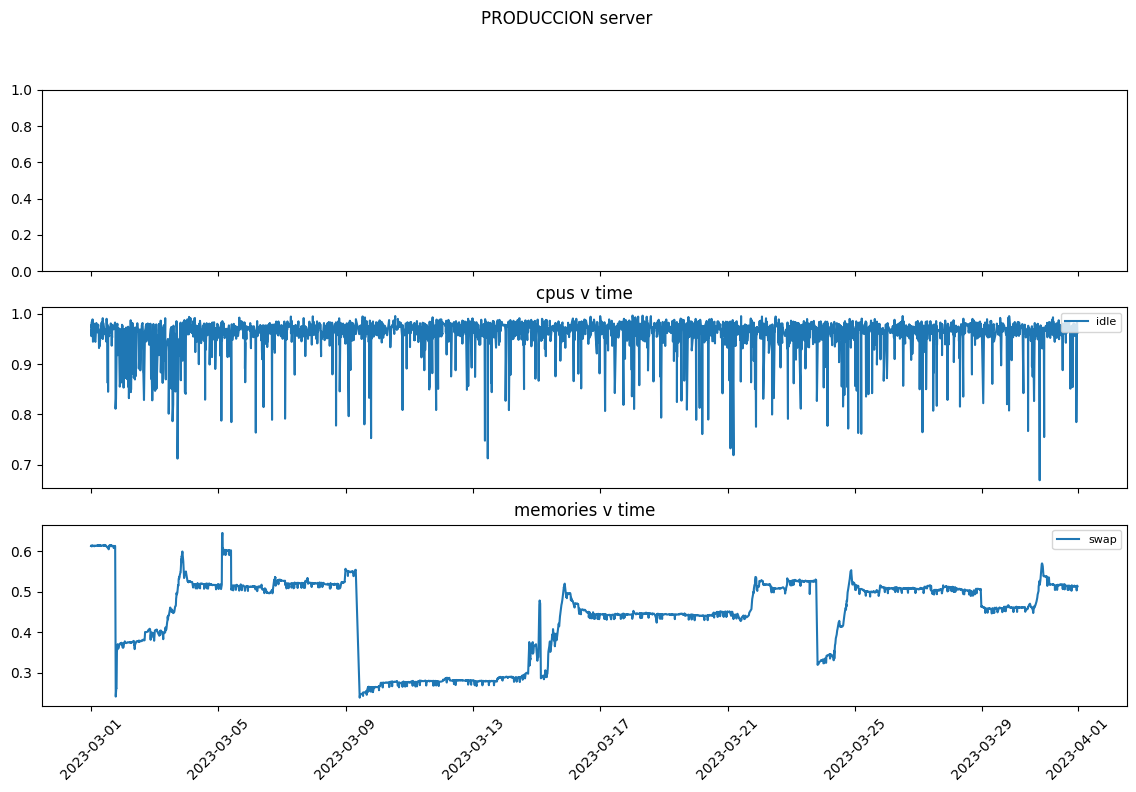

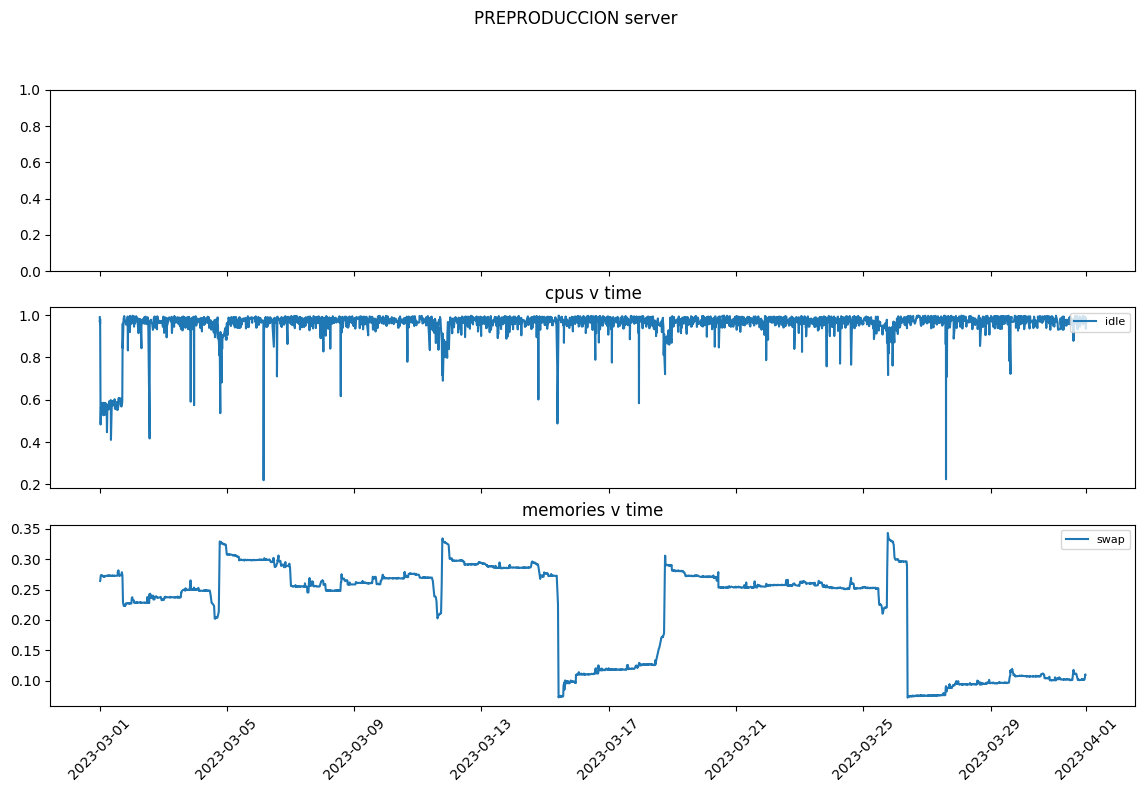

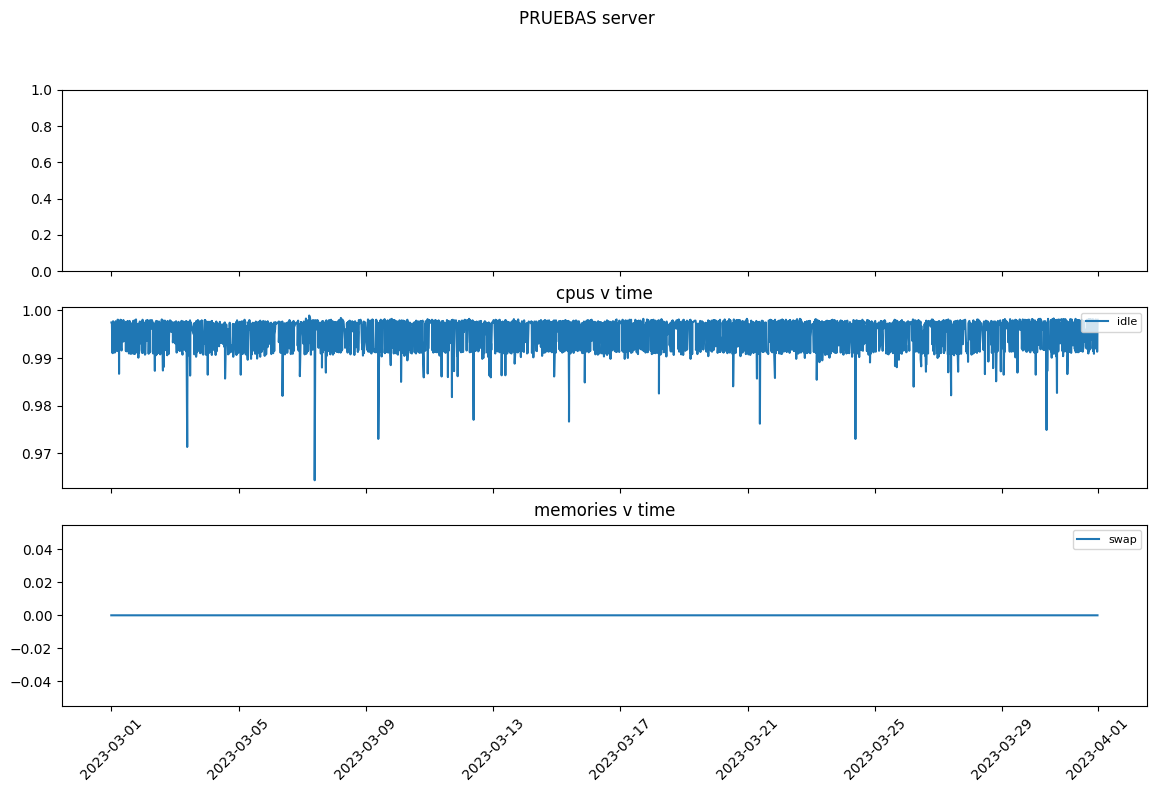

In [131]:
hostnames = data["host"].unique()            # get unique names
hostnames = list(map(read_json, hostnames))  # get json files
hostnames_values = np.array([list(hostnames[i].values()) for i in range(len(hostnames))])
for i in range(5):
    plot(hostnames[i]["name"])